# Titanic Dataset Analysis and Model Evaluation

This notebook performs data analysis, preprocessing, feature engineering, and trains multiple machine learning models for both classification and regression tasks. The dataset used is the Titanic dataset.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingClassifier,
)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE


## Load the Dataset

Load the Titanic dataset for training and testing.


In [6]:
# Load the Titanic dataset
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

## Data Cleaning

Handle missing values in the `Age` and `Embarked` columns, and drop the `Cabin` column due to a high percentage of missing data.

In [7]:
# Fill missing values in the 'Age' column with the median
age_imputer = SimpleImputer(strategy="median")
train_data["Age"] = age_imputer.fit_transform(train_data[["Age"]])

# Fill missing values in the 'Embarked' column with the most frequent value
embarked_imputer = SimpleImputer(strategy="most_frequent")
train_data["Embarked"] = embarked_imputer.fit_transform(train_data[["Embarked"]]).ravel()

# Drop the 'Cabin' column due to a large number of missing values
train_data.drop(columns=["Cabin"], inplace=True)


## Exploratory Data Analysis (EDA)

Visualize the data to understand its distribution and relationships between features.


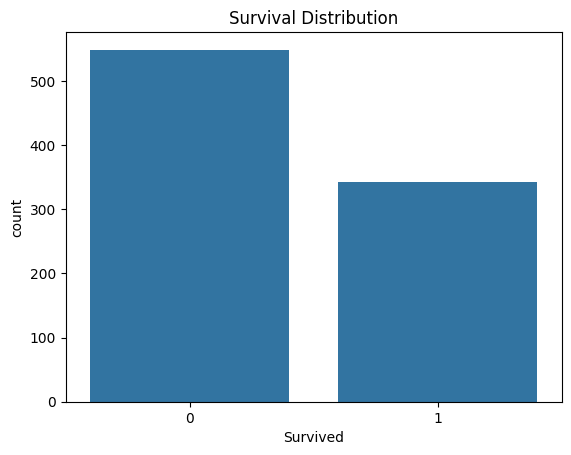

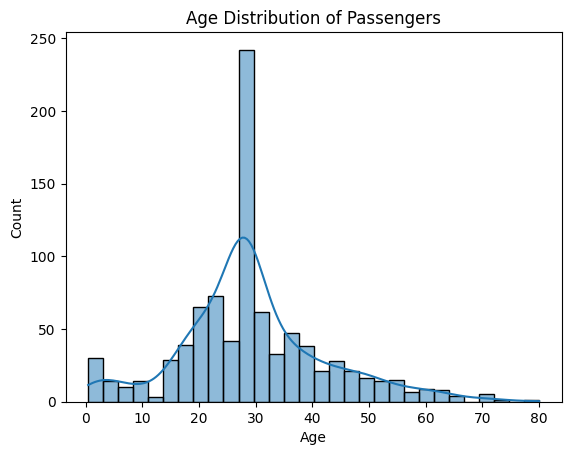

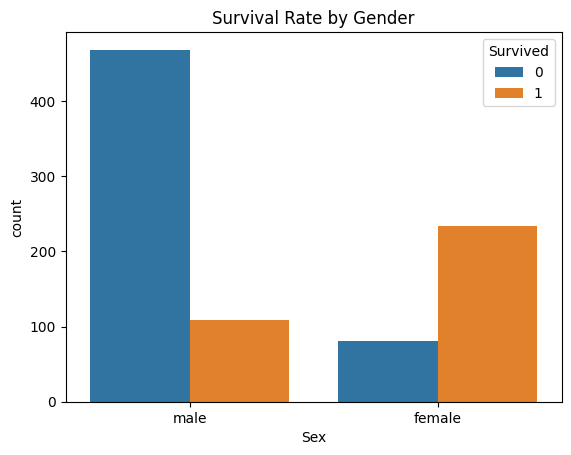

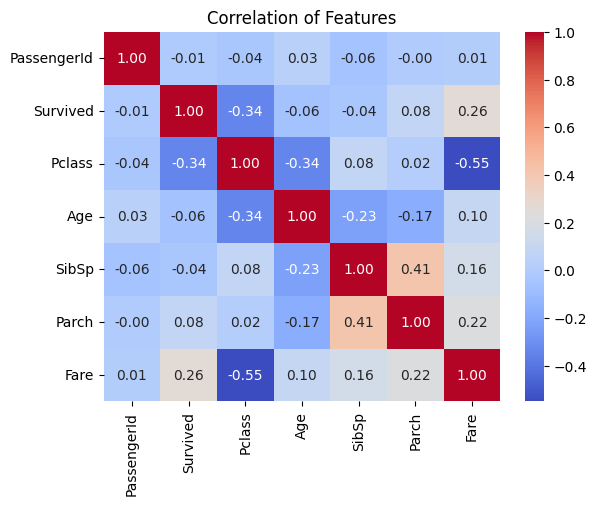

In [8]:
# Plot survival distribution
sns.countplot(data=train_data, x="Survived")
plt.title("Survival Distribution")
plt.show()

# Plot age distribution
sns.histplot(data=train_data, x="Age", kde=True)
plt.title("Age Distribution of Passengers")
plt.show()

# Plot survival rate by gender
sns.countplot(data=train_data, x="Sex", hue="Survived")
plt.title("Survival Rate by Gender")
plt.show()

# Plot correlation heatmap for numeric features
numeric_columns = train_data.select_dtypes(include=["number"])
corr_matrix = numeric_columns.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of Features")
plt.show()


## Feature Engineering

Perform feature encoding, scaling, and creation of new features for better model performance.


In [9]:
# Encode categorical features using LabelEncoder
label_encoder = LabelEncoder()
train_data["Sex"] = label_encoder.fit_transform(train_data["Sex"])
train_data["Embarked"] = label_encoder.fit_transform(train_data["Embarked"])

# Create a new feature 'FamilySize'
train_data["FamilySize"] = train_data["SibSp"] + train_data["Parch"] + 1

# Drop irrelevant features
train_data.drop(columns=["Name", "Ticket"], inplace=True)

# Scale numerical features
scaler = StandardScaler()
train_data[["Age", "Fare"]] = scaler.fit_transform(train_data[["Age", "Fare"]])


## Classification Task

Train and evaluate different classification models to predict survival (`Survived` column).


In [10]:
# Define features and target variable
X = train_data.drop(columns=["Survived"])
y = train_data["Survived"]

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Function to train and evaluate a model
def evaluate_model(model):
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    print(f"\n{model.__class__.__name__}:")
    print(classification_report(y_val, preds))
    return accuracy_score(y_val, preds)


### Decision Tree Classifier


In [11]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_param_grid = {"max_depth": [None, 5, 10], "min_samples_split": [2, 5]}
dt_grid_search = GridSearchCV(dt_model, dt_param_grid, cv=5)
dt_grid_search.fit(X_train, y_train)
print(f"Best parameters for Decision Tree: {dt_grid_search.best_params_}")
evaluate_model(dt_grid_search.best_estimator_)


Best parameters for Decision Tree: {'max_depth': 5, 'min_samples_split': 5}

DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       103
           1       0.86      0.84      0.85       117

    accuracy                           0.84       220
   macro avg       0.84      0.84      0.84       220
weighted avg       0.84      0.84      0.84       220



0.8409090909090909

### Random Forest Classifier


In [12]:
rf_model = RandomForestClassifier(random_state=42)
rf_param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [None, 10],
    "min_samples_split": [2, 5],
}
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5)
rf_grid_search.fit(X_train, y_train)
print(f"Best parameters for Random Forest: {rf_grid_search.best_params_}")
evaluate_model(rf_grid_search.best_estimator_)


Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}

RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.83      0.90      0.87       103
           1       0.91      0.84      0.87       117

    accuracy                           0.87       220
   macro avg       0.87      0.87      0.87       220
weighted avg       0.87      0.87      0.87       220



0.8681818181818182

### Logistic Regression


In [13]:
lr_model = LogisticRegression(random_state=42, max_iter=2000)
lr_param_grid = {"C": [0.01, 0.1, 1.0], "solver": ["liblinear"]}
lr_grid_search = GridSearchCV(lr_model, lr_param_grid, cv=5)
lr_grid_search.fit(X_train, y_train)
print(f"Best parameters for Logistic Regression: {lr_grid_search.best_params_}")
evaluate_model(lr_grid_search.best_estimator_)


Best parameters for Logistic Regression: {'C': 1.0, 'solver': 'liblinear'}

LogisticRegression:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       103
           1       0.81      0.85      0.83       117

    accuracy                           0.82       220
   macro avg       0.82      0.82      0.82       220
weighted avg       0.82      0.82      0.82       220



0.8181818181818182

### Gradient Boosting Classifier

In [14]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_param_grid = {
    "n_estimators": [50, 100],
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5],
}
gb_grid_search = GridSearchCV(gb_model, gb_param_grid, cv=5)
gb_grid_search.fit(X_train, y_train)
print(f"Best parameters for Gradient Boosting: {gb_grid_search.best_params_}")
evaluate_model(gb_grid_search.best_estimator_)


Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

GradientBoostingClassifier:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       103
           1       0.86      0.86      0.86       117

    accuracy                           0.85       220
   macro avg       0.85      0.85      0.85       220
weighted avg       0.85      0.85      0.85       220



0.8545454545454545

## Regression Task

Train and evaluate regression models to predict the age of passengers.


In [15]:
# Prepare regression data
reg_data = train_data.dropna(subset=["Age"])
reg_target = reg_data["Age"]
reg_features = reg_data.drop(columns=["Age", "Survived"])

X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(
    reg_features, reg_target, test_size=0.2, random_state=42
)


### Linear Regression


In [16]:
lr_reg_model = LinearRegression()
lr_reg_model.fit(X_train_reg, y_train_reg)
lr_reg_preds = lr_reg_model.predict(X_val_reg)
print("\nLinear Regression:")
print(f"RMSE: {mean_squared_error(y_val_reg, lr_reg_preds, squared=False):.2f}")


Linear Regression:
RMSE: 0.91


c:\Users\denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Random Forest Regressor

In [17]:
rf_reg_model = RandomForestRegressor(random_state=42)
rf_reg_param_grid = {"n_estimators": [50, 100], "max_depth": [None, 10]}
rf_reg_grid_search = GridSearchCV(rf_reg_model, rf_reg_param_grid, cv=5)
rf_reg_grid_search.fit(X_train_reg, y_train_reg)
print(f"Best parameters for Random Forest Regressor: {rf_reg_grid_search.best_params_}")
rf_reg_preds = rf_reg_grid_search.predict(X_val_reg)
print("\nRandom Forest Regressor:")
print(f"RMSE: {mean_squared_error(y_val_reg, rf_reg_preds, squared=False):.2f}")


Best parameters for Random Forest Regressor: {'max_depth': 10, 'n_estimators': 100}

Random Forest Regressor:
RMSE: 0.88


c:\Users\denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
